# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Enter The Tabular Data Model!

And now - we put Tabular Data Models to the test.



In [1]:
# imports

import os
import sys
import re
import math
import json
import random
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import joblib


In [2]:
# Import the machine learning libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tabpfn import TabPFNClassifier



In [3]:
# Get the root project directory (one level up from the docs folder)
root_project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the src folder to the path
sys.path.insert(0, os.path.join(root_project_path, "src"))

In [4]:
from items import Item


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from testing import Tester

In [6]:
# environment

load_dotenv()


True

In [7]:
%matplotlib inline

In [9]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('../data/train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('../data/test.pkl', 'rb') as file:
    test = pickle.load(file)

## First, the TabPFN

It's called TabPFN, Its a foundation model for tabular data that outperforms traditional methods while being dramatically faster. This repository contains the core PyTorch implementation with CUDA optimization.

In [10]:
train[0].details

'[{"timestamp": 1709370000, "room": "livingroom", "nodeId": 5, "endpointId": 1, "attribute": {"OccupancySensing": {"Occupancy": 1}}, "datetime": "Sat Mar 02 2024 09:00:00"}, {"timestamp": 1709370000, "room": "livingroom", "nodeId": 5, "endpointId": 3, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 2100}}, "datetime": "Sat Mar 02 2024 09:00:00"}, {"timestamp": 1709370900, "room": "livingroom", "nodeId": 5, "endpointId": 4, "attribute": {"Event": {"Event": "window_opened"}}, "datetime": "Sat Mar 02 2024 09:15:00"}, {"timestamp": 1709371200, "room": "livingroom", "nodeId": 5, "endpointId": 3, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1800}}, "datetime": "Sat Mar 02 2024 09:20:00"}, {"timestamp": 1709371500, "room": "livingroom", "nodeId": 5, "endpointId": 3, "attribute": {"TemperatureMeasurement": {"MeasuredValue": 1500}}, "datetime": "Sat Mar 02 2024 09:25:00"}, {"timestamp": 1709373600, "room": "livingroom", "nodeId": 5, "endpointId": 4, "attribute": {"Event":

In [11]:
#Here comments some feature engineering to convert the raw sensor data into meaningful features dynamically.
def flatten_entry(entry):
    """Flatten a single JSON-like entry with indexed keys."""
    flat_dict = {}
    logs = json.loads(entry.details.strip())


    for i, log in enumerate(logs):
        for key, value in log.items():
            flat_dict[f"{i}.{key}"] = value

    flat_dict['result'] = entry.result
    return flat_dict

def prepare_features(data):
    """Convert the raw sensor data into meaningful features dynamically."""
    features = {}
    
    # Load events from data.details (which could be a JSON string, list of JSON strings, or list of dicts)
    if isinstance(data.details, str):
        events = json.loads(data.details)
    elif isinstance(data.details, list) and all(isinstance(item, str) for item in data.details):
        events = [json.loads(event) for event in data.details]
    else:  
        events = data.details

    # Dynamic room counts: count visits for every room seen in the events
    room_counts = {}
    for event in events:
        room = event.get('room')
        if room is not None:
            room_counts[room] = room_counts.get(room, 0) + 1
    # Add dynamic room count features (keys will be like 'room_kitchen_visits', etc.)
    for room, count in room_counts.items():
        features[f'room_{room}_visits'] = count

    # Timestamp based features:
    # Calculate average and maximum time between consecutive events
    timestamps = [event.get('timestamp') for event in events if 'timestamp' in event]
    if len(timestamps) > 1:
        diffs = np.diff(timestamps)
        features['avg_time_between_events'] = float(np.mean(diffs))
        features['max_time_between_events'] = float(np.max(diffs))
    else:
        features['avg_time_between_events'] = 0.0
        features['max_time_between_events'] = 0.0
    
    # Count rapid transitions (events less than 2 minutes apart)
    rapid_transitions = 0
    for i in range(len(timestamps) - 1):
        if timestamps[i+1] - timestamps[i] < 120:
            rapid_transitions += 1
    features['rapid_transitions'] = rapid_transitions

    # Attribute features:
    # For each attribute present, create a feature (e.g., "TemperatureMeasurement_MeasuredValue")
    # and aggregate by taking the average value for that attribute over the period.
    attr_values = {}  # key: feature name, value: list of measurements
    for event in events:
        attr = event.get('attribute', {})
        # Each event's attribute is assumed to be a dict with a single key
        for attr_name, inner in attr.items():
            # inner is a dict (e.g., {"MeasuredValue": 1901} or {"Occupancy": 1})
            for inner_key, value in inner.items():
                feature_key = f"{attr_name}_{inner_key}"
                try:
                    numeric_value = float(value)
                except (ValueError, TypeError):
                    continue
                if feature_key not in attr_values:
                    attr_values[feature_key] = []
                attr_values[feature_key].append(numeric_value)
    
    # Compute the average for each attribute feature if available
    for key, values in attr_values.items():
        features[key] = float(np.mean(values))
    
    return features


In [12]:
prepare_features(test[2])

{'room_livingroom_visits': 6,
 'room_kitchen_visits': 4,
 'room_bedroom_visits': 1,
 'avg_time_between_events': 720.0,
 'max_time_between_events': 2400.0,
 'rapid_transitions': 3,
 'OccupancySensing_Occupancy': 0.5714285714285714,
 'OnOff_OnOff': 0.5}

In [13]:
# We are going to flatten the log entries and turn into tabular data

def flatten_entry(entry):
    """Flatten a single JSON-like entry with indexed keys."""
    flat_dict = {}
    logs = json.loads(entry.details.strip())


    for i, log in enumerate(logs):
        for key, value in log.items():
            flat_dict[f"{i}.{key}"] = value

    flat_dict['result'] = entry.result
    return flat_dict


def prepare_tabular_data2(data, feature_names=None):
    """Convert a list of JSON entries into a Pandas DataFrame."""
    flattened_data = [flatten_entry(entry) for entry in data]
    df = pd.DataFrame(flattened_data)
    df = df.fillna('missing')  # Handle missing values
    
    if feature_names:
        missing_features = {feature: 'missing' for feature in feature_names if feature not in df.columns}
        df = pd.concat([df, pd.DataFrame(missing_features, index=df.index)], axis=1)
        df = df[feature_names]
    
    return df.astype(str)  # Ensure all data is of string type

def prepare_tabular_data(data, feature_names=None):
    """Convert a list of JSON entries into a Pandas DataFrame with engineered features."""
    flattened_data = []
    for entry in data:
        features = prepare_features(entry)
        features['result'] = entry.result
        flattened_data.append(features)
    
    df = pd.DataFrame(flattened_data)
    df = df.fillna('missing')  # Handle missing values
    
    if feature_names:
        missing_features = {feature: 'missing' for feature in feature_names if feature not in df.columns}
        df = pd.concat([df, pd.DataFrame(missing_features, index=df.index)], axis=1)
        df = df[feature_names]
    
    return df.astype(str)  # Ensure all data is of string type

In [14]:
prepare_tabular_data(train)

,room_livingroom_visits,avg_time_between_events,max_time_between_events,rapid_transitions,OccupancySensing_Occupancy,TemperatureMeasurement_MeasuredValue,result,room_kitchen_visits,room_bathroom_visits,OnOff_OnOff,RelativeHumidityMeasurement_MeasuredValue,room_bedroom_visits,room_porch_visits,room_pillbox_visits,room_hall_visits,room_diningroom_visits
0,8.0,771.4285714285714,2100.0,1,1.0,1800.0,anomalous,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,6.0,766.6666666666666,2400.0,4,0.5555555555555556,2250.0,normal,4.0,3.0,1.0,7500.0,missing,missing,missing,missing,missing
2,4.0,969.2307692307693,3600.0,4,0.5,missing,normal,4.0,2.0,missing,missing,2.0,2.0,missing,missing,missing
3,missing,540.0,2900.0,8,0.5294117647058824,missing,anomalous,missing,12.0,missing,5650.0,9.0,missing,missing,missing,missing
4,8.0,771.4285714285714,2100.0,1,1.0,1800.0,anomalous,missing,missing,missing,missing,missing,missing,missing,missing,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,missing,1285.7142857142858,2200.0,1,0.6666666666666666,missing,anomalous,missing,7.0,missing,6700.0,1.0,missing,missing,missing,missing
82,2.0,692.3076923076923,3600.0,4,0.5454545454545454,2100.0,normal,4.0,2.0,missing,missing,3.0,2.0,missing,1.0,missing
83,missing,600.0,600.0,0,0.0,missing,anomalous,missing,7.0,1.0,8700.0,missing,missing,missing,missing,missing
84,missing,2880.0,3600.0,0,1.0,2300.0,anomalous,missing,missing,0.5,missing,11.0,missing,missing,missing,missing


In [15]:
# We will train the anomlay detector using the tabPFN model

def train_anomaly_detector(json_data):
    """Train a TabPFN model to detect anomalies."""
    df = prepare_tabular_data(json_data)
    
    # Separate features and labels
    X = df.drop(columns=['result'], errors='ignore')
    y = (df['result'] == 'anomalous').astype(int)  # Binary classification

    # Convert all columns to string type to avoid type issues
    X = X.astype(str)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize TabPFN classifier
    model = TabPFNClassifier()
    model.fit(X_train, y_train)

    # Predict probabilities
    prediction_probabilities = model.predict_proba(X_test)
    print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

    # Predict labels
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    return model, X_train.columns.tolist()


In [16]:
# Lets create a model
model, feature_names = train_anomaly_detector(train)

ROC AUC: 0.9870129870129869
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.92      1.00      0.96        11

    accuracy                           0.94        18
   macro avg       0.96      0.93      0.94        18
weighted avg       0.95      0.94      0.94        18



In [17]:
# We make a function to predict an anomaly
def predict_anomaly(model, new_data, feature_names):
    """Predict if a new datapoint is anomalous using TabPFN."""
    df = prepare_tabular_data([new_data], feature_names)
    X = df.drop(columns=['result'], errors='ignore')

    # Ensure no NaN values are present
    X = X.fillna('missing')

    # Ensure the feature order matches the training order
    X = X[feature_names]

    prediction = model.predict(X)
    probability = model.predict_proba(X)

    return {
        'is_anomalous': bool(prediction[0]),
        'confidence': float(max(probability[0])),
        'features_used': list(X.columns)
    }


In [18]:
test[0].details

'[{"timestamp": 1709341500, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_opened"}}, "datetime": "Sat Mar 02 2024 01:05:00"}, {"timestamp": 1709341530, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_closed"}}, "datetime": "Sat Mar 02 2024 01:05:30"}, {"timestamp": 1709346600, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_opened"}}, "datetime": "Sat Mar 02 2024 02:30:00"}, {"timestamp": 1709346630, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_closed"}}, "datetime": "Sat Mar 02 2024 02:30:30"}, {"timestamp": 1709351700, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_opened"}}, "datetime": "Sat Mar 02 2024 03:55:00"}, {"timestamp": 1709351730, "room": "entrance", "nodeId": 7, "endpointId": 1, "attribute": {"Event": {"Event": "door_closed"}}, "datetime": "Sat Mar 02 2024 03:55:30

In [19]:
# Example usage:
result = predict_anomaly(model, test[0], feature_names)
print(result)

{'is_anomalous': True, 'confidence': 0.9651414752006531, 'features_used': ['room_livingroom_visits', 'avg_time_between_events', 'max_time_between_events', 'rapid_transitions', 'OccupancySensing_Occupancy', 'TemperatureMeasurement_MeasuredValue', 'room_kitchen_visits', 'room_bathroom_visits', 'OnOff_OnOff', 'RelativeHumidityMeasurement_MeasuredValue', 'room_bedroom_visits', 'room_porch_visits', 'room_pillbox_visits', 'room_hall_visits', 'room_diningroom_visits']}


In [20]:
def tabpfn_anomaly_assessor(item):
    """Wrapper function to assess anomalies using TabPFN."""
    result = predict_anomaly(model, item, feature_names)
    return 'anomalous' if result['is_anomalous'] else 'normal'

1: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709341500, "room": "entr...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738090800, "room": "livi...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1741046400, "room": "livi...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1741082100, "room": "hall...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709344800, "room": "bedr...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1709298000, "room": "kitc...
7: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1709427600, "datetime": "...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1804198800, "datetime": "...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1737856800, "datetime": "...
10: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1737849600, "datetime": "...
11: Guess: anomalous Tr

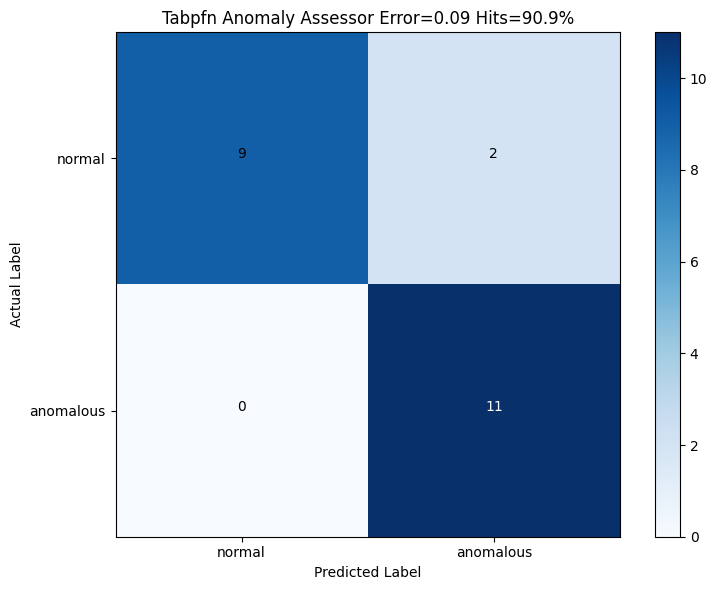

In [21]:
#Now lets run the test
Tester.test(tabpfn_anomaly_assessor, test)


# Now we should save our classification model

In [23]:
# Save the model and scaler to a file

joblib.dump((model, feature_names), '../data/tabpfn_model.pkl')

['../data/tabpfn_model.pkl']